### PRE-ENTREGA 3


Grupo 15

Belen Massuco - Andrea Rodriguez

Fecha de entrega: 18 de junio 2025

INTRODUCCIÓN

Para nuestro proyecto final, seleccionamos un dataset de estadísticas agrícolas históricas de Argentina, proveniente del portal oficial del Ministerio de Agricultura. Este dataset incluye registros desde el ciclo agrícola 1969/1970 hasta 2022/2023, con información organizada por provincia y departamento. Las variables principales son:

- provincia_nombre: Nombre de la provincia
- departamento_nombre: Nombre del departamento
- cultivo: Nombre del cultivo
- ciclo: Año de la campaña
- sup_sembrada: Cantidad de superficie semabrada en hectareas
- sup_cosechada: Cantidad de superficie cosechada en hectareas
- produccion: Cantidad de produccion en toneladas
- rendimiento: Cantidad de rendimiento en kilos por hectarea

Fuente dataset: https://datos.magyp.gob.ar/dataset/estimaciones-agricolas

En esta etapa se trabajó sobre:
- Modelo de aprendizaje supervisado.
- Ajuste de modelos de clasificación o regresión.
- Evaluación de los modelos.
- Optimización de hiperparámetros.

OBJETIVO:

Predecir la producción de los 3 cultivos con mayor producción histórica.



### Cargamos librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Cargamos y exploramos dataset

Se trabaja con mismo dataset de la pre-entrega 2

In [3]:
# Importar dataset
df = pd.read_csv('estimaciones_agricolas.csv', encoding='latin1', delimiter=',', dtype={9: object, 10: object, 11: object})

In [4]:
# Mostrar primeras observaciones
df.head()

,provincia_id,provincia_nombre,departamento_id,departamento_nombre,id_cultivo,cultivo,id_ciclo,ciclo,sup_sembrada,sup_cosechada,produccion,rendimiento
0,6,Buenos Aires,854,25 de Mayo,1.0,Ajo,1,1969/1970,3,3,10,3333
1,6,Buenos Aires,14,Adolfo Gonzales Chaves,1.0,Ajo,1,1969/1970,15,15,82,5467
2,6,Buenos Aires,21,Alberti,1.0,Ajo,1,1969/1970,5,5,7,1400
3,6,Buenos Aires,28,Almirante Brown,1.0,Ajo,1,1969/1970,2,2,8,4000
4,6,Buenos Aires,77,Arrecifes,1.0,Ajo,1,1969/1970,6,6,15,2500


In [5]:
# Mostrar cantidad de registros/observaciones y features
ff = df.shape
print(f'El dataset contiene {ff[0]} observaciones y {ff[1]} features.')

El dataset contiene 153889 observaciones y 12 features.


In [6]:
# Ver tipos de datos
df.dtypes

,0
provincia_id,int64
provincia_nombre,object
departamento_id,int64
departamento_nombre,object
id_cultivo,float64
cultivo,object
id_ciclo,int64
ciclo,object
sup_sembrada,int64
sup_cosechada,object


In [7]:
# Nombre de features
df.columns

Index(['provincia_id', 'provincia_nombre', 'departamento_id',
       'departamento_nombre', 'id_cultivo', 'cultivo', 'id_ciclo', 'ciclo',
       'sup_sembrada', 'sup_cosechada', 'produccion', 'rendimiento'],
      dtype='object')

In [8]:
# Renombrar features - agregar unidades
df.rename(columns={'sup_sembrada': 'sup_sembrada_ha', 'sup_cosechada': 'sup_cosechada_ha', 'produccion': 'produccion_ton', 'rendimiento':'rendimiento_kg/ha'}, inplace=True)

In [9]:
# Se convierten las columnas sup_cosechada_ha', 'produccion_ton' y 'rendimiento_kg/ha' de object a float/int
columns_to_convert = ['sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha']

# Limpiar y convertir a float/int
for col in columns_to_convert:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)  # eliminar separadores de miles
    df[col] = df[col].str.replace(',', '.', regex=False)             # cambiar coma decimal por punto
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [10]:
# Verificar resultado
print(df[columns_to_convert].dtypes)

sup_cosechada_ha     float64
produccion_ton       float64
rendimiento_kg/ha    float64
dtype: object


### Creación y selección de features

**Región**

In [11]:
# Diccionario de provincias agrupadas por región
region_map = {
    'Santiago del Estero': 'NOA',
    'Tucuman': 'NOA',
    'Catamarca': 'NOA',
    'Jujuy': 'NOA',
    'Salta': 'NOA',
    'La Rioja': 'NOA',

    'Chaco': 'NEA',
    'Corrientes': 'NEA',
    'Formosa': 'NEA',
    'Misiones': 'NEA',

    'Buenos Aires': 'Pampeana',
    'Santa Fe': 'Pampeana',
    'Cordoba': 'Pampeana',
    'Entre Rios': 'Pampeana',
    'La Pampa': 'Pampeana',


    'Mendoza': 'Cuyo',
    'San Juan': 'Cuyo',
    'San Luis': 'Cuyo',

    'Neuquen': 'Patagonia',
    'Rio Negro': 'Patagonia',
    'Chubut': 'Patagonia',
    'Santa Cruz': 'Patagonia',
    'Tierra del Fuego': 'Patagonia'
}

In [12]:
df['region'] = df['provincia_nombre'].map(region_map)

**Tasa de cosecha**

In [13]:
df['tasa_cosecha'] = df['sup_cosechada_ha'] / df['sup_sembrada_ha']

**Año**

In [14]:
df['anio'] = df['ciclo'].str[:4].astype(int)

*Se eliminan columnas*.

- provincia_nombre: se elimina porque se decide trabajar por regiones dónde éstas ya son representadas.
- provincia_id: se elimina porque ya no aporta valor.
- departamento_id: no sera útil en este análisis
- departamento_nombre: no sera útil en este análisis
- id_ciclo: no será útil en este análisis
- ciclo: la reemplaza la feature anio
- id_cultivo: no será útil en este análisis

*Para el análisis se usaran*:

- 'region'
- 'cultivo'
- 'sup_sembrada_ha'
- 'sup_cosechada_ha'
- 'produccion_ton'
- 'rendimiento_kg/ha'
- 'tasa_cosecha'
- 'anio'

In [15]:
df.drop(columns=['provincia_id', 'provincia_nombre', 'departamento_id', 'departamento_nombre',
                 'id_ciclo', 'ciclo', 'id_cultivo'], inplace=True)

### Estadística descriptiva de variables numéricas

Analizamos las principales variables cuantitativas del dataset: superficie sembrada y cosechada (en hectáreas), producción total (en toneladas), rendimiento (en kg/ha) y tasa de cosecha (cosechada / sembrada).

In [16]:
print(df[['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']].describe())

       sup_sembrada_ha  sup_cosechada_ha  produccion_ton  rendimiento_kg/ha  \
count     1.538890e+05      1.538760e+05    1.538750e+05      153875.000000   
mean      1.228560e+04      1.075362e+04    3.331973e+04        3489.310772   
std       3.585014e+04      3.436686e+04    1.276209e+05        5577.586344   
min       0.000000e+00      0.000000e+00    0.000000e+00           0.000000   
25%       1.800000e+02      6.100000e+01    1.800000e+02        1000.000000   
50%       1.439000e+03      8.000000e+02    1.790000e+03        1919.000000   
75%       8.500000e+03      6.000000e+03    1.400000e+04        3501.000000   
max       1.096100e+06      1.066100e+06    8.620000e+06      300000.000000   

       tasa_cosecha  
count  1.506520e+05  
mean            inf  
std             NaN  
min    0.000000e+00  
25%    6.551724e-01  
50%    9.636364e-01  
75%    1.000000e+00  
max             inf  


/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


El mínimo para las variables analizadas resultó cero.


In [17]:
# Contar valores igual a cero
(df[['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']] == 0).sum()


,0
sup_sembrada_ha,3225
sup_cosechada_ha,16314
produccion_ton,13147
rendimiento_kg/ha,16348
tasa_cosecha,13090


Chequeo de valores nulos en la feature "sup_sembrada_ha" ya que el mínimo estadístico es cero

In [18]:
df['sup_sembrada_ha'].sort_values().head(5)

,sup_sembrada_ha
3338,0
3339,0
3340,0
3341,0
3342,0


Aunque el resumen estadístico muestra un valor mínimo de 0 en la superficie sembrada, al inspeccionar los registros más bajos se comprobó que no existen valores nulos reales. Los valores mínimos observados son de 1 o 2 hectáreas, lo que puede corresponder a registros de pequeña escala. Por lo tanto, se concluye que la superficie sembrada siempre fue mayor que cero en los datos analizados.

Mostrar filas con datos con valor cero

In [19]:
df[(df['sup_cosechada_ha'] == 0) |
   (df['produccion_ton'] == 0) |
   (df['rendimiento_kg/ha'] == 0) |
   (df['tasa_cosecha'] == 0)]

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio
307,Algodón,6,0.0,0.0,0.0,NOA,0.0,1969
410,Alpiste,100,0.0,0.0,0.0,Pampeana,0.0,1969
496,Avena,2500,0.0,0.0,0.0,Pampeana,0.0,1969
498,Avena,100,0.0,0.0,0.0,Pampeana,0.0,1969
501,Avena,3000,0.0,0.0,0.0,Pampeana,0.0,1969
...,...,...,...,...,...,...,...,...
153492,Sorgo,1000,0.0,0.0,0.0,Pampeana,0.0,2022
153567,Sorgo,450,0.0,0.0,0.0,NOA,0.0,2022
153754,Trigo total,0,0.0,0.0,0.0,NEA,NaN,2022
153796,Trigo total,0,0.0,0.0,0.0,NOA,NaN,2022


Durante el análisis exploratorio, se identificaron registros en los que la superficie sembrada es distinta de cero, pero no se registra superficie cosechada. Estos casos pueden deberse a pérdidas totales por eventos climáticos, abandono del cultivo, decisiones económicas o errores en la carga de datos.

Dado que representan situaciones reales del proceso agrícola, se decidió conservarlos en esta etapa con el objetivo de evaluar su impacto potencial en el modelo de machine learning que se desarrollará posteriormente. Su inclusión permitirá analizar si estas situaciones extremas contienen información útil para la predicción o si, por el contrario, generan ruido que justifique su exclusión futura.

### Análisis por cultivo

**Chequeo de cultivos**: cantidad de cultivos 42





In [20]:
df['cultivo'].nunique()

42

Con el objetivo de enfocar el análisis en los cultivos de mayor impacto productivo a nivel nacional, se procedió a identificar aquellos con la mayor producción total acumulada en el período disponible. Para ello, se agruparon los datos por tipo de cultivo y se sumó la producción total en toneladas.

In [21]:
# Se agrupan los datos por cultivo y se suma por feature produccion
cultivos_produccion = df.groupby('cultivo')['produccion_ton'].sum().reset_index()

# Ordenamos por produccion en orden descendente
cultivos_produccion = cultivos_produccion.sort_values(by='produccion_ton', ascending=False)

# Se muestran los cultivos con mayor hectárea sembrada
print("Cultivos con mayor producción a nivel nacional:")
print(cultivos_produccion.head(4))

Cultivos con mayor producción a nivel nacional:
        cultivo  produccion_ton
35   Soja total    1.224195e+09
23         Maíz    1.039261e+09
33     Soja 1ra    8.240707e+08
38  Trigo total    6.373855e+08


'Soja 1ra' no se va a considerar ya que está incluída en 'Soja total'

A partir de este análisis, se seleccionaron los tres cultivos con mayor volumen de producción como subconjunto de interés.

In [22]:
# Filtramos dataset considerando sólo 3 cultivos
df.drop(df[~df['cultivo'].isin(['Soja total', 'Maíz', 'Trigo total'])].index, inplace=True)

In [23]:
df['cultivo'].unique()

array(['Maíz', 'Soja total', 'Trigo total'], dtype=object)

Chequeo valores nulos en el nuevo dataset

In [24]:
df.isnull().sum()

,0
cultivo,0
sup_sembrada_ha,0
sup_cosechada_ha,1
produccion_ton,2
rendimiento_kg/ha,2
region,0
tasa_cosecha,4
anio,0


No hay valores nulos

In [25]:
df[df.isna().any(axis=1)]

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio
139560,Maíz,2200,NaN,NaN,NaN,Pampeana,NaN,2017
140106,Maíz,100,100.0,NaN,NaN,NOA,1.0,2017
153754,Trigo total,0,0.0,0.0,0.0,NEA,NaN,2022
153796,Trigo total,0,0.0,0.0,0.0,NOA,NaN,2022
153798,Trigo total,0,0.0,0.0,0.0,NOA,NaN,2022


Hay 5 filas con variables numéricas igual a cero o NaN

In [26]:
df['sup_sembrada_ha'].sort_values().head(5)

,sup_sembrada_ha
153798,0
153796,0
153754,0
6549,1
11652,1


Superfice sembrada tiene 3 filas nulas. Este valor no se puede recuperar por eso se decide eliminar estas filas.

In [27]:
df = df[df['sup_sembrada_ha'] != 0]

In [28]:
df[df.isna().any(axis=1)]

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio
139560,Maíz,2200,NaN,NaN,NaN,Pampeana,NaN,2017
140106,Maíz,100,100.0,NaN,NaN,NOA,1.0,2017


Como hay 2 filas con valores NaN en producción pero además en rendimiento, se decide eliminarlas ya que no se pueden recuperar con precisión.

In [29]:
df = df.dropna(subset=['produccion_ton'])

In [30]:
# Chequeo de filas con valores cero o NaN
df[df.isna().any(axis=1)]

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio


In [31]:
# Mostrar cantidad de registros/observaciones y features
ff = df.shape
print(f'El dataset contiene {ff[0]} observaciones y {ff[1]} features.')

El dataset contiene 41271 observaciones y 8 features.


Se eliminaron las filas con valores 'NaN', son sólo 5 filas en una base de datos de arriba de 40mil observaciones. Además, no hay suficiente información contextual para estimarlos de forma confiable.

Se continua con la visualización de los datos

### Visualización de datos

Estadísticas de variables numéricas

In [32]:
print(df[['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']].describe())

       sup_sembrada_ha  sup_cosechada_ha  produccion_ton  rendimiento_kg/ha  \
count     4.127100e+04      4.127100e+04    4.127100e+04       41271.000000   
mean      2.507804e+04      2.313258e+04    7.028765e+04        2672.677086   
std       5.356877e+04      5.174875e+04    1.742528e+05        1889.604017   
min       1.000000e+00      0.000000e+00    0.000000e+00           0.000000   
25%       1.000000e+03      7.000000e+02    1.300000e+03        1443.000000   
50%       5.700000e+03      4.700000e+03    1.160000e+04        2125.000000   
75%       2.600000e+04      2.250000e+04    6.350000e+04        3290.500000   
max       1.096100e+06      1.066100e+06    3.412500e+06       33333.000000   

       tasa_cosecha  
count  41271.000000  
mean       0.856121  
std        0.238476  
min        0.000000  
25%        0.827586  
50%        0.972727  
75%        1.000000  
max        1.001961  


El dataset contiene 41.271 registros con gran variabilidad en las variables clave. La superficie sembrada y cosechada promedian alrededor de 25.000 y 23.000 hectáreas, respectivamente, con rangos que van desde parcelas muy pequeñas hasta extensas superficies. La producción media es de 70.000 toneladas, aunque con valores muy dispersos y algunos extremos muy altos. El rendimiento promedio es de 2.673 kg/ha, mostrando amplia variabilidad, desde cero hasta casos excepcionales. La tasa de cosecha ronda el 86%, con algunos registros de cosecha nula o ligeramente superiores al 100%, posiblemente por errores o ajustes.

Filtramos dataset para visualización de datos según región y cultivo

In [33]:
region_data = df.groupby(['region','cultivo'])[['produccion_ton', 'rendimiento_kg/ha', 'sup_sembrada_ha', 'sup_cosechada_ha', 'tasa_cosecha']].sum().reset_index()
print(f'{region_data}')

       region      cultivo  produccion_ton  rendimiento_kg/ha  \
0        Cuyo         Maíz    2.892310e+07          1868561.0   
1        Cuyo   Soja total    9.553981e+06           334859.0   
2        Cuyo  Trigo total    6.441030e+05           455488.0   
3         NEA         Maíz    2.541552e+07          7240223.0   
4         NEA   Soja total    3.222777e+07          3415366.0   
5         NEA  Trigo total    4.104932e+06          1375849.0   
6         NOA         Maíz    9.341597e+07          9619251.0   
7         NOA   Soja total    9.858979e+07          4000308.0   
8         NOA  Trigo total    1.837150e+07          2815351.0   
9    Pampeana         Maíz    8.913983e+08         42542465.0   
10   Pampeana   Soja total    1.083823e+09         15585515.0   
11   Pampeana  Trigo total    6.141075e+08         20152545.0   
12  Patagonia         Maíz    1.083120e+05           612210.0   
13  Patagonia  Trigo total    1.574810e+05           286065.0   

    sup_sembrada_ha  sup

Se decide eliminar la región 'Patagonia', ya que contiene valores con varios ordenes de magnitud menor en comparación a otras regiones, por tanto el aporte no es significativo.

In [34]:
df.drop(df[df['region'] == 'Patagonia'].index, inplace=True)

Se grafican para los 3 cultivos

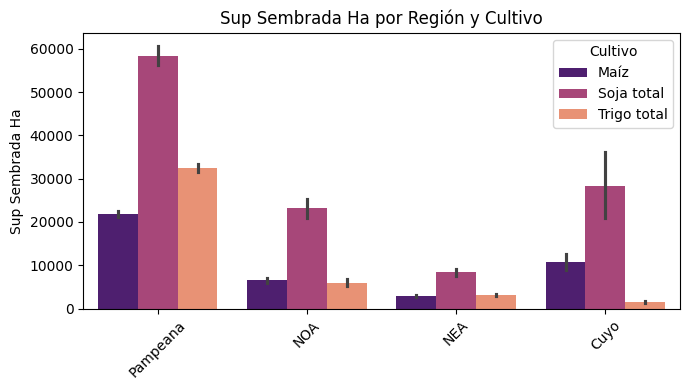

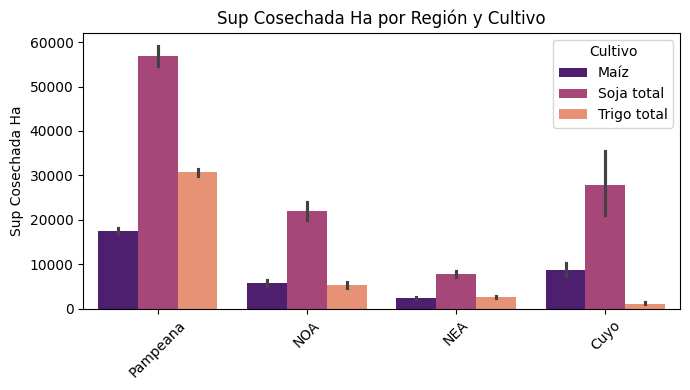

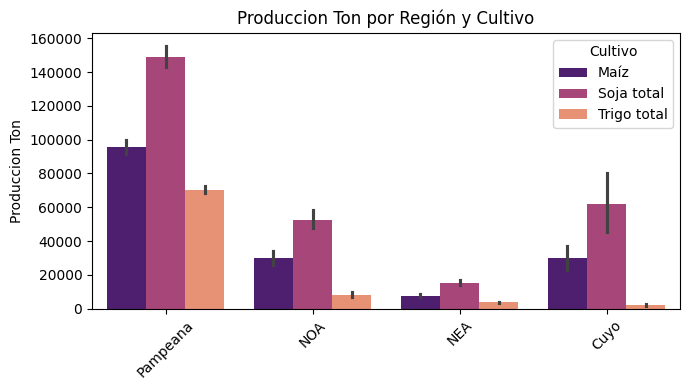

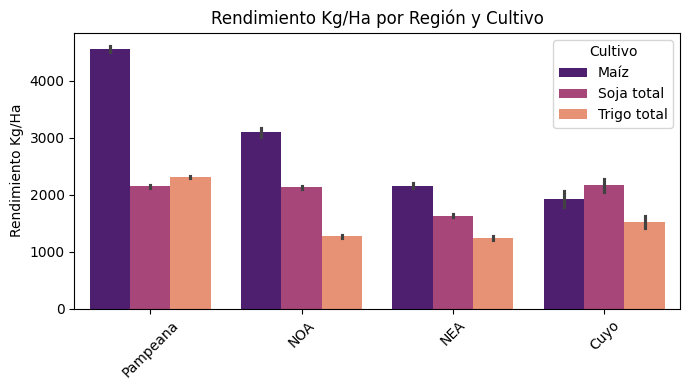

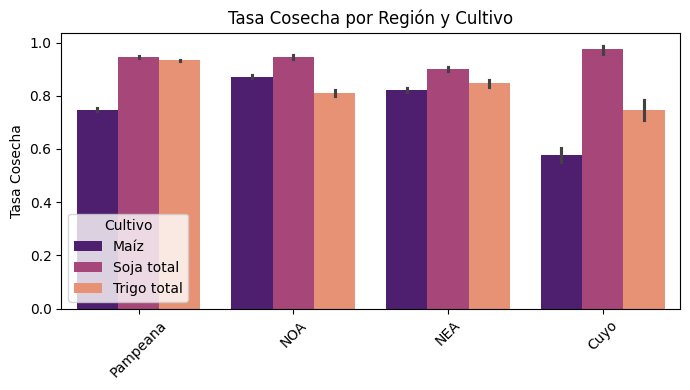

In [35]:
# Gráficamos para cada métrica
for metric in ['sup_sembrada_ha', 'sup_cosechada_ha', 'produccion_ton', 'rendimiento_kg/ha', 'tasa_cosecha']:
    plt.figure(figsize=(7, 4))
    sns.barplot(x='region', y=metric, hue='cultivo', data=df, palette='magma')
    plt.title(f'{metric.replace("_", " ").title()} por Región y Cultivo')
    plt.xlabel('')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.legend(title='Cultivo')
    plt.tight_layout()
    plt.savefig(f'{metric.replace("/", "_")}_por_region_y_cultivo.png')
    plt.show()

🌱 Superficie sembrada por región y cultivo

La región Pampeana concentra ampliamente la mayor parte de la superficie sembrada para los tres cultivos, destacándose la soja con más de 60.000 hectáreas. Le sigue el trigo y luego el maíz. En las demás regiones, la superficie sembrada es notablemente menor, aunque Cuyo y NOA muestran una participación importante en soja. El trigo y el maíz tienen menor presencia en NEA y Cuyo, reflejando diferencias agroecológicas y de estrategia productiva regional.

🌾 Superficie cosechada

La distribución de la superficie cosechada replica el patrón de la siembra, indicando que la mayoría de la superficie sembrada efectivamente se cosecha, especialmente en la región Pampeana. Se observan leves diferencias en otras regiones, como en Cuyo, donde la superficie cosechada de trigo es sensiblemente menor a la sembrada, lo que podría estar asociado a condiciones climáticas adversas o limitaciones operativas.

📈 Producción total

La producción sigue la tendencia de la superficie y los rendimientos: la soja en la región Pampeana es el cultivo estrella, con valores de producción que superan las 140.000 toneladas. El maíz también alcanza altos volúmenes, seguido por el trigo. En NOA y Cuyo, la soja también lidera, aunque con menor volumen. En general, el peso de la región Pampeana en la producción nacional es indiscutible.

⚖️ Rendimiento (Kg/Ha)

Los mayores rendimientos se alcanzan con el maíz en la región Pampeana (más de 4.500 kg/ha), lo que evidencia un manejo técnico eficiente y condiciones agroclimáticas óptimas. La soja y el trigo tienen rendimientos más bajos y estables, aunque la soja en Cuyo sorprende con un buen desempeño. En cambio, el trigo en NOA y NEA muestra los valores más bajos, evidenciando limitantes agronómicas o climáticas.

✅ Tasa de cosecha

La tasa de cosecha es alta en la mayoría de las regiones y cultivos, con valores cercanos al 1 (100%), lo cual indica una eficiencia operativa generalizada. Sin embargo, se destaca que en Cuyo, el maíz tiene una tasa sensiblemente más baja (aprox. 0,58), lo que sugiere pérdidas o cosechas incompletas, posiblemente por condiciones desfavorables o baja rentabilidad. La soja muestra gran consistencia en todas las regiones, con tasas cercanas al 100%.

In [ ]:
df.to_csv('df_modelado.csv', index=False)

### **CONCEPTOS**

🔹 Regresión Lineal

- Supone una relación lineal entre las variables independientes y la dependiente.

- Fácil de interpretar, pero limitada para relaciones no lineales.

🔹 Random Forest Regressor

- Modelo basado en ensamble de árboles de decisión.

- Captura relaciones no lineales y funciona bien con variables categóricas codificadas.

- Es robusto frente al overfitting.



## **Modelo supervisado dataset completo**

### Importar librerias

In [36]:
from sklearn.preprocessing import OneHotEncoder
from pandas import DataFrame
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

### Preprocesamiento de datos

In [37]:
df.to_csv('df_modelado.csv', index=False)

In [38]:
df_new = df

In [39]:
#Se resetea el index
df_new = df_new.reset_index(drop=True)

In [40]:
# Visualizar primeras filas
df_new.head()

,cultivo,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,region,tasa_cosecha,anio
0,Maíz,36000,33000.0,102300.0,3100.0,Pampeana,0.916667,1969
1,Maíz,25000,23000.0,73600.0,3200.0,Pampeana,0.920000,1969
2,Maíz,9000,5000.0,6500.0,1300.0,Pampeana,0.555556,1969
3,Maíz,1400,150.0,210.0,1400.0,Pampeana,0.107143,1969
4,Maíz,14400,14000.0,48000.0,3429.0,Pampeana,0.972222,1969


In [41]:
# Chequear tamaño
df_new.shape

(40504, 8)

### **OneHotEncoder --> CULTIVO**

**One Hot Encoding** para transformar variables categóricas en un formato numérico que los modelos pudieran entender.

In [42]:
# OneHotEncoder para la feature 'cultivo'
encoderC = OneHotEncoder()

In [43]:
encoderC.fit_transform(df_new[['cultivo']]).toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [44]:
encoderC.categories_

[array(['Maíz', 'Soja total', 'Trigo total'], dtype=object)]

In [45]:
niveles = encoderC.categories_[0].tolist()

In [46]:
one_hot_cultivo = pd.DataFrame(encoderC.fit_transform(df_new[['cultivo']]).toarray(), columns=niveles)

In [47]:
one_hot_cultivo

,Maíz,Soja total,Trigo total
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
40499,0.0,0.0,1.0
40500,0.0,0.0,1.0
40501,0.0,0.0,1.0
40502,0.0,0.0,1.0


In [48]:
# Uniendo columnas
df2 = pd.concat([df_new, one_hot_cultivo], axis=1)

### **OneHotEncoder --> REGIÓN**

In [49]:
# OneHotEncoder para la feature 'region'
encoderR = OneHotEncoder()

In [50]:
encoderR.fit_transform(df_new[['region']]).toarray()

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [51]:
encoderR.categories_

[array(['Cuyo', 'NEA', 'NOA', 'Pampeana'], dtype=object)]

In [52]:
nivelesR = encoderR.categories_[0].tolist()

In [53]:
one_hot_encoderR = pd.DataFrame(encoderR.fit_transform(df_new[['region']]).toarray(), columns=nivelesR)

In [54]:
one_hot_encoderR

,Cuyo,NEA,NOA,Pampeana
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
40499,0.0,0.0,1.0,0.0
40500,0.0,0.0,1.0,0.0
40501,0.0,0.0,1.0,0.0
40502,0.0,0.0,1.0,0.0


In [55]:
# Uniendo columnas
df3 = pd.concat([df2, one_hot_encoderR], axis=1)

In [56]:
# Eliminamos columnas con datos duplicados
df3 = df3.drop('region', axis=1)
df3 = df3.drop('cultivo', axis=1)

In [57]:
df3.head()

,sup_sembrada_ha,sup_cosechada_ha,produccion_ton,rendimiento_kg/ha,tasa_cosecha,anio,Maíz,Soja total,Trigo total,Cuyo,NEA,NOA,Pampeana
0,36000,33000.0,102300.0,3100.0,0.916667,1969,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,25000,23000.0,73600.0,3200.0,0.920000,1969,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9000,5000.0,6500.0,1300.0,0.555556,1969,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1400,150.0,210.0,1400.0,0.107143,1969,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,14400,14000.0,48000.0,3429.0,0.972222,1969,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [58]:
df3.shape

(40504, 13)

### Modelado supervisado

In [59]:
# Cargamos dataset procesado
df3.to_csv('df_onehot.csv', index=False)

In [60]:
# Definimos variable objetivo
y = df3["produccion_ton"]
# Variables predictoras: todas menos la target
X = df3.drop(columns=["produccion_ton"])

In [61]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
X_train.shape

(32403, 12)

In [63]:
X_test.shape

(8101, 12)

In [64]:
# Modelo Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [65]:
# Modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [66]:
# Métricas de evaluación
def evaluar(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

In [67]:
# Evaluación de ambos modelos
mae_lr, rmse_lr, r2_lr = evaluar(y_test, y_pred_lr)
mae_rf, rmse_rf, r2_rf = evaluar(y_test, y_pred_rf)

In [68]:
# Mostrar resultados
print("Regresión Lineal:")
print(f"  MAE:  {mae_lr:.2f}")
print(f"  RMSE: {rmse_lr:.2f}")
print(f"  R²:   {r2_lr:.2f}")

print("\nRandom Forest Regressor:")
print(f"  MAE:  {mae_rf:.2f}")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  R²:   {r2_rf:.2f}")

Regresión Lineal:
  MAE:  32551.07
  RMSE: 69073.10
  R²:   0.84

Random Forest Regressor:
  MAE:  1278.67
  RMSE: 13573.66
  R²:   0.99


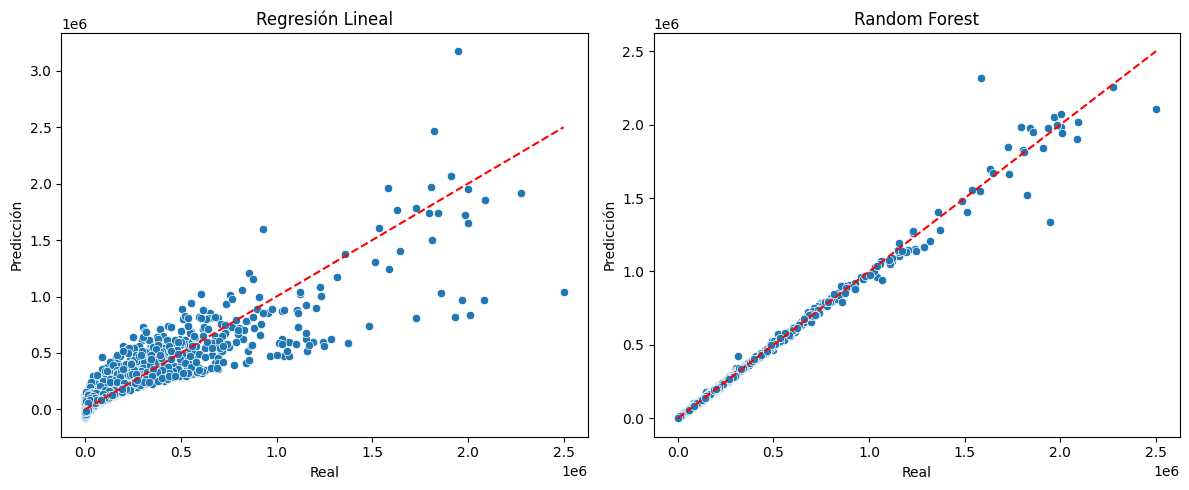

In [69]:
# Visualización comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Regresión Lineal")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.tight_layout()
plt.show()

### Importancia de features

rf.feature_importances_ es un atributo del modelo Random Forest entrenado con scikit‑learn que indica cuánto aporta cada variable a las predicciones del bosque. Sirve principalmente para:

- Interpretar el modelo: saber qué variables pesan más en la toma de decisiones.

- Seleccionar variables: descartar las de baja importancia y simplificar el modelo.

In [70]:
importances = rf.feature_importances_
features = X.columns
importancia_df = pd.DataFrame({"Feature": features, "Importancia": importances})
importancia_df = importancia_df.sort_values(by="Importancia", ascending=False)

/tmp/ipython-input-71-4106902020.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importancia", y="Feature", data=importancia_df.head(15), palette="viridis")


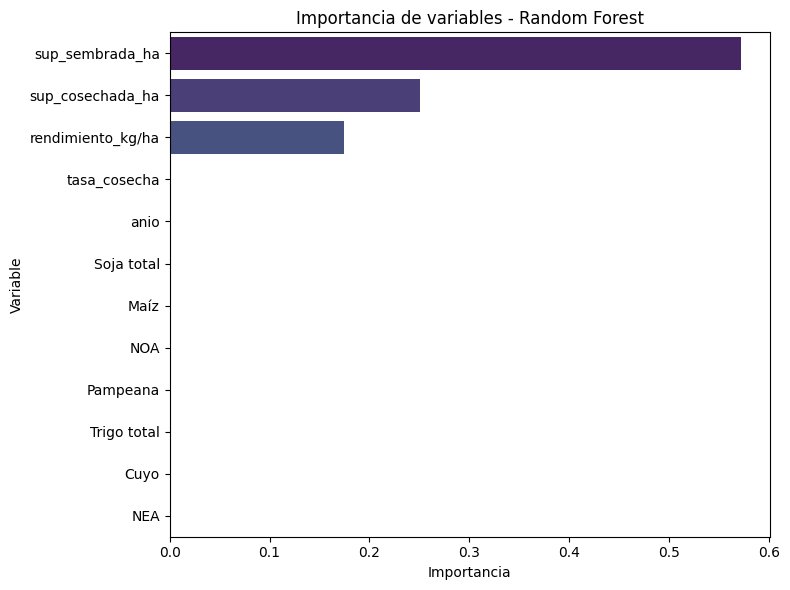

In [71]:
plt.figure(figsize=(8, 6))
sns.barplot(x="Importancia", y="Feature", data=importancia_df.head(15), palette="viridis")
plt.title("Importancia de variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

El modelo ha identificado que solo 3 variables contienen la mayor parte de la información útil para predecir el resultado. Las demás tienen poca o ninguna relevancia en la toma de decisiones.

### Mejora de hiperparámetros

In [72]:
# Definir variable objetivo y predictoras seleccionadas
y = df["produccion_ton"]
X = df[["sup_sembrada_ha", "sup_cosechada_ha", "rendimiento_kg/ha"]]

In [73]:
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
# Definir modelo base
rf = RandomForestRegressor(random_state=42)

In [76]:
# Definir hiperparámetros a explorar
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

In [77]:
# Búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,  # cantidad de combinaciones
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [78]:
# Entrenar el modelo con búsqueda
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [79]:
# Usar el mejor modelo encontrado
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

In [80]:
# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred_best)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

In [81]:
# Imprimir resultados
print("Mejor configuración encontrada:")
print(random_search.best_params_)

print("\nMétricas con el mejor modelo:")
print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²:   {r2:.3f}")

Mejor configuración encontrada:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}

Métricas con el mejor modelo:
  MAE:  1149.99
  RMSE: 12593.64
  R²:   0.995


In [83]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

# Resultados promedio
print("\nVALIDACIÓN CRUZADA (5-fold):")
print(f"  MAE train:  {-cv_results['train_neg_mean_absolute_error'].mean():.2f}")
print(f"  MAE val:    {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"  RMSE train: {-cv_results['train_neg_root_mean_squared_error'].mean():.2f}")
print(f"  RMSE val:   {-cv_results['test_neg_root_mean_squared_error'].mean():.2f}")
print(f"  R² train:   {cv_results['train_r2'].mean():.3f}")
print(f"  R² val:     {cv_results['test_r2'].mean():.3f}")



VALIDACIÓN CRUZADA (5-fold):
  MAE train:  488.60
  MAE val:    1299.11
  RMSE train: 4291.48
  RMSE val:   12671.77
  R² train:   0.999
  R² val:     0.995



MAE (Mean Absolute Error): Mide el error promedio en las predicciones. Cuanto más bajo, mejor.

RMSE (Root Mean Squared Error): Penaliza más los errores grandes (cuadrático). También, más bajo es mejor.

R² (Coeficiente de determinación): Mide qué tan bien explica el modelo la variación de la variable objetivo. Valor entre 0 y 1.


- Un MAE de 1299 representa apenas un 1% o menos del valor típico.

- Un RMSE de 12.672 suena grande, pero tiene sentido si hay algunos valores extremos.

- Un R² de 0.995 en validación es excelente, indica que se explica el 99.5% de la variabilidad.

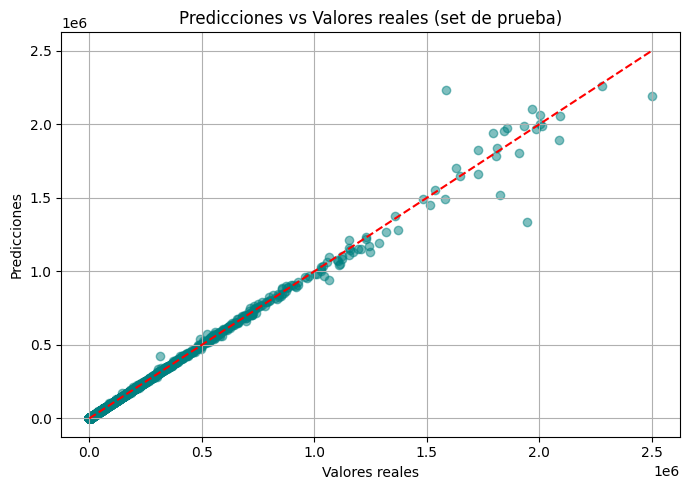

In [85]:
import matplotlib.pyplot as plt

y_pred = best_rf.predict(X_test)

plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (set de prueba)')
plt.grid(True)
plt.tight_layout()
plt.show()


El modelo generaliza muy bien en el set de prueba. No hay grandes desviaciones ni agrupamientos raros.

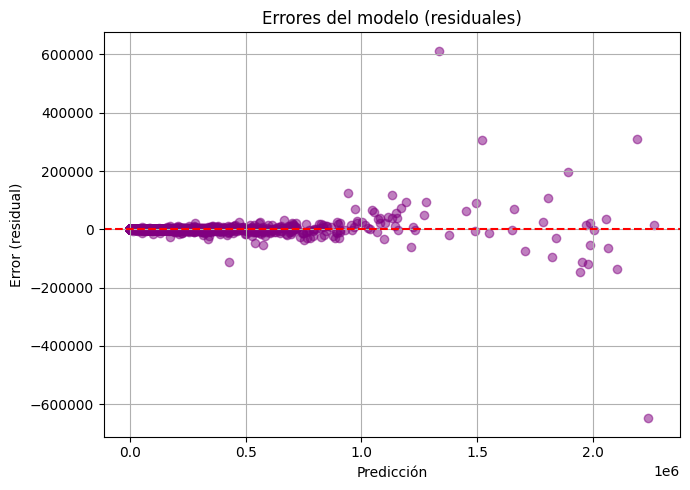

In [86]:
residuals = y_test - y_pred

plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicción')
plt.ylabel('Error (residual)')
plt.title('Errores del modelo (residuales)')
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo no muestra sesgos evidentes. El error crece un poco para valores altos (esperable en datos con mayor varianza), pero no hay indicios fuertes de sobreajuste ni de mala especificación del modelo.

## **Modelo supervisado por cultivo**

Decidimos entrenar un modelo específico para cada cultivo, ya que cada uno tiene dinámicas propias, distintos factores climáticos, tecnológicos y de mercado que impactan en su producción.

### Cultivo: Maíz

Predecir la producción (en toneladas) de maíz para distintos años, regiones y superficies sembradas/cosechadas utilizando dos modelos:

- Regresión Lineal

- Random Forest Regressor (con búsqueda de hiperparámetros)

In [87]:
# Filtramos dataset por cultivo maíz
df_maiz = df[df['cultivo'] == 'Maíz'].copy()

#Variables del modelo
X_maiz = df_maiz[['region', 'sup_sembrada_ha', 'sup_cosechada_ha', 'anio']]
y_maiz = df_maiz['produccion_ton']

# Codificación de la región
X_maiz = pd.get_dummies(X_maiz, columns=['region'], drop_first=True)

In [88]:
from sklearn.model_selection import train_test_split

X_train_maiz, X_test_maiz, y_train_maiz, y_test_maiz = train_test_split(X_maiz, y_maiz, test_size=0.2, random_state=42)

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 1: Regresión Lineal
lr_maiz = LinearRegression()
lr_maiz.fit(X_train_maiz, y_train_maiz)
y_pred_lr_maiz = lr_maiz.predict(X_test_maiz)

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 2: Random Forest
rf_maiz = RandomForestRegressor(n_estimators=100, random_state=42)
rf_maiz.fit(X_train_maiz, y_train_maiz)
y_pred_rf_maiz = rf_maiz.predict(X_test_maiz)

In [91]:
# Metricas
rms_maiz_rf = mean_squared_error(y_test_maiz, y_pred_rf_maiz)
mae_maiz_rf = mean_absolute_error(y_test_maiz, y_pred_rf_maiz)
r2_maiz_rf = r2_score(y_test_maiz, y_pred_rf_maiz)

rms_maiz_l = mean_squared_error(y_test_maiz, y_pred_lr_maiz)
mae_maiz_l = mean_absolute_error(y_test_maiz, y_pred_lr_maiz)
r2_maiz_l = r2_score(y_test_maiz, y_pred_lr_maiz)

print(f'Metricas para Regresión Lineal: MAE: {mae_maiz_l:.2f} | R²: {r2_maiz_l:.2f} | RMS: {rms_maiz_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_maiz_rf:.2f} | R²: {r2_maiz_rf:.2f} | RMS: {rms_maiz_rf:.2f}')

Metricas para Regresión Lineal: MAE: 27990.84 | R²: 0.84 | RMS: 4861031019.61
Metricas para Random Forest: MAE: 11255.85 | R²: 0.96 | RMS: 1170666544.74


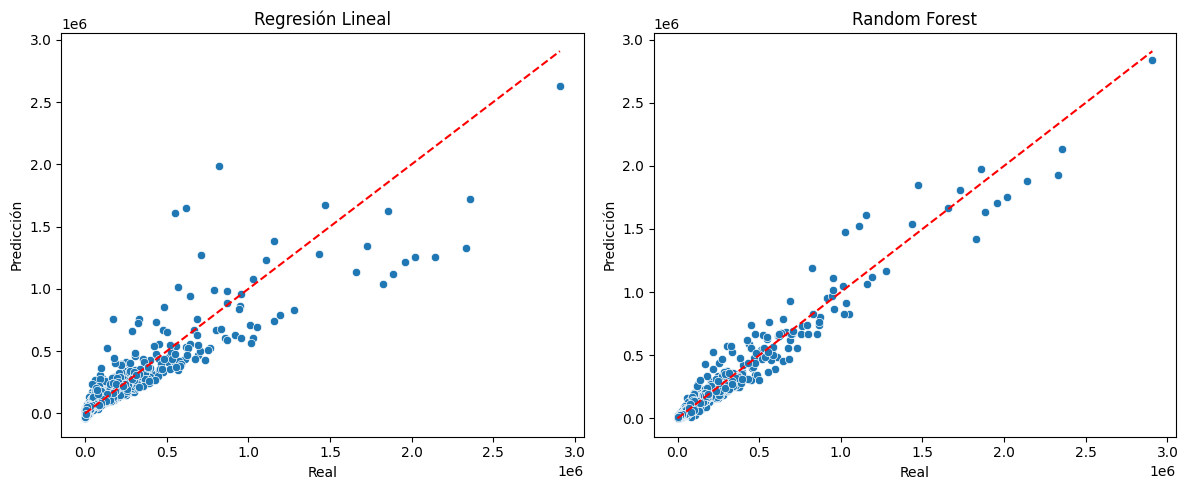

In [92]:
# Visualización comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_maiz, y=y_pred_lr_maiz)
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.title("Regresión Lineal")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_maiz, y=y_pred_rf_maiz)
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.tight_layout()
plt.show()

Hiperparámetros

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV

# Modelo base
#rf = RandomForestRegressor()

#param_grid = {
    #'n_estimators': [100, 300, 500],            # Más árboles pueden mejorar estabilidad
    #'max_depth': [10, 20, 30, None],            # Limita profundidad para evitar overfitting
    #'min_samples_split': [2, 5, 10],            # Min. muestras para dividir nodo
    #'min_samples_leaf': [1, 2, 4],              # Min. muestras en una hoja
    #'max_features': ['sqrt', 'log2', None]      # Qué fracción de features se considera}

# RandomizedSearch
#random_search_maiz = RandomizedSearchCV(
    #estimator=rf,
    #param_distributions=param_grid,
    #n_iter=50,  # Cuántas combinaciones probar
    #cv=5,
    #verbose=2,
    #random_state=42,
    #n_jobs=-1)

# Entrenamiento
#random_search_maiz.fit(X_train_maiz, y_train_maiz)

# Mejor modelo encontrado
#best_rf = random_search_maiz.best_estimator_
#print("Mejores hiperparámetros:", random_search_maiz.best_params_)


Mejores hiperparámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20}


In [93]:
# modifico hiperparámetros
rf_model_maiz = RandomForestRegressor(n_estimators=500, min_samples_split=2, min_samples_leaf=1, max_features=None , max_depth=20, random_state=42)
rf_model_maiz.fit(X_train_maiz, y_train_maiz)

y_pred_maiz = rf_model_maiz.predict(X_test_maiz)

In [94]:
# Metricas
rms = mean_squared_error(y_test_maiz, y_pred_maiz)
mae = mean_absolute_error(y_test_maiz, y_pred_maiz)
r2 = r2_score(y_test_maiz, y_pred_maiz)


print('Modelos iniciales para Maíz')
print(f'Metricas para Regresión Lineal: MAE: {mae_maiz_l:.2f} | R²: {r2_maiz_l:.2f} | RMS: {rms_maiz_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_maiz_rf:.2f} | R²: {r2_maiz_rf:.2f} | RMS: {rms_maiz_rf:.2f}')
print('\n')
print('Modelos optimizados')
print(f'MAE: {mae:.2f} | R²: {r2:.2f} | RMS: {rms:.2f}')

Modelos iniciales para Maíz
Metricas para Regresión Lineal: MAE: 27990.84 | R²: 0.84 | RMS: 4861031019.61
Metricas para Random Forest: MAE: 11255.85 | R²: 0.96 | RMS: 1170666544.74


Modelos optimizados
MAE: 11188.91 | R²: 0.96 | RMS: 1149125947.22


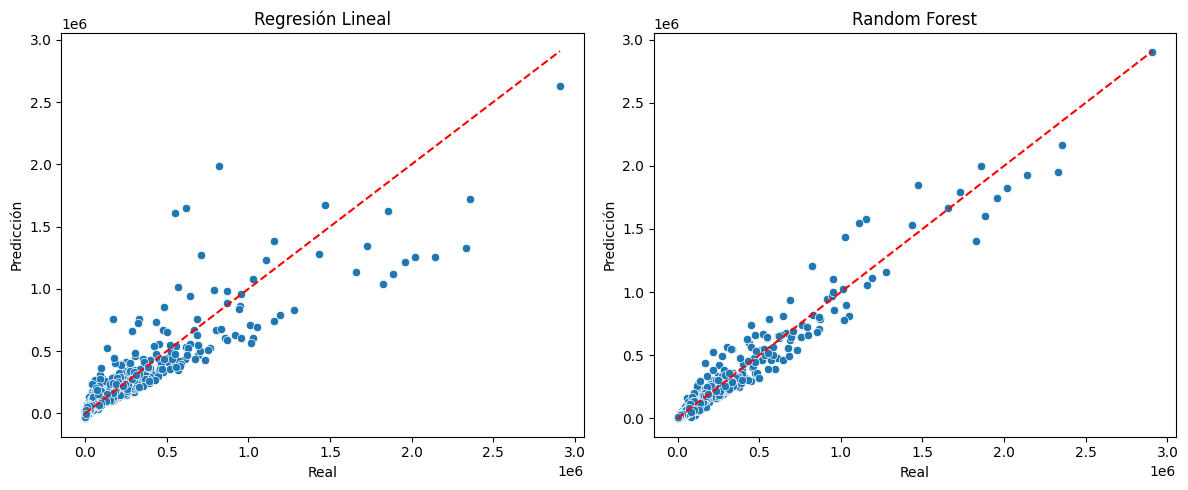

In [95]:
# Visualización comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_maiz, y=y_pred_lr_maiz)
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.title("Regresión Lineal")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_maiz, y=y_pred_maiz)
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.tight_layout()
plt.show()

La regresión lineal logra una buena relación (R²=0.83), pero aún deja errores de decenas de miles de toneladas.

Random Forest reduce drásticamente el error medio, mostrando que captura mejor patrones no lineales.

Optimización:

Con parámetros: n_estimators=500, max_depth=20, min_samples_split=2, min_samples_leaf=1, max_features=None se perfeccionó el modelo.
La mejora fue moderada pero permitió afinar detalles que pueden ser cruciales en decisiones estratégicas.

In [96]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    rf_model_maiz,
    X_train_maiz,
    y_train_maiz,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

# Resultados promedio
print("\nVALIDACIÓN CRUZADA (5-fold):")
print(f"  MAE train:  {-cv_results['train_neg_mean_absolute_error'].mean():.2f}")
print(f"  MAE val:    {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"  RMSE train: {-cv_results['train_neg_root_mean_squared_error'].mean():.2f}")
print(f"  RMSE val:   {-cv_results['test_neg_root_mean_squared_error'].mean():.2f}")
print(f"  R² train:   {cv_results['train_r2'].mean():.3f}")
print(f"  R² val:     {cv_results['test_r2'].mean():.3f}")



VALIDACIÓN CRUZADA (5-fold):
  MAE train:  4560.59
  MAE val:    12094.93
  RMSE train: 14325.51
  RMSE val:   39435.33
  R² train:   0.993
  R² val:     0.947


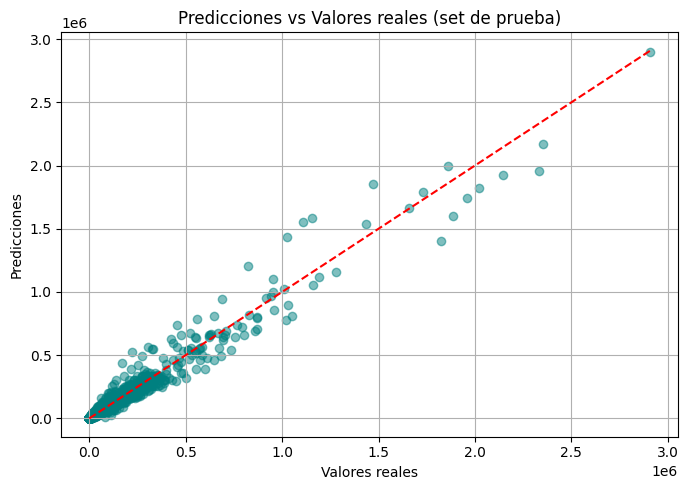

In [97]:
import matplotlib.pyplot as plt

y_pred_maiz = rf_model_maiz.predict(X_test_maiz)

plt.figure(figsize=(7, 5))
plt.scatter(y_test_maiz, y_pred_maiz, alpha=0.5, color='teal')
plt.plot([y_test_maiz.min(), y_test_maiz.max()], [y_test_maiz.min(), y_test_maiz.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (set de prueba)')
plt.grid(True)
plt.tight_layout()
plt.show()


El modelo predice muy bien en general, pero pierde algo de precisión en los valores altos. Esto es común en modelos no lineales como Random Forest cuando hay pocos ejemplos de alta magnitud o gran dispersión en ese rango.

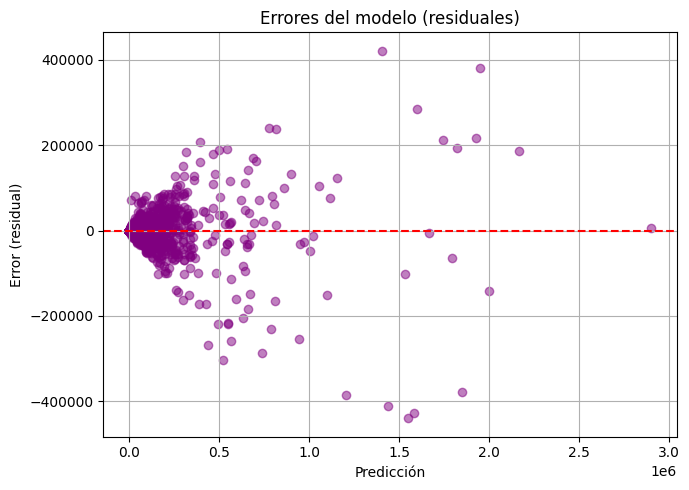

In [98]:
residuals_maiz = y_test_maiz - y_pred_maiz

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_maiz, residuals_maiz, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicción')
plt.ylabel('Error (residual)')
plt.title('Errores del modelo (residuales)')
plt.grid(True)
plt.tight_layout()
plt.show()

No hay señales evidentes de sesgo estructural. El modelo mantiene una varianza aceptable considerando que la variable objetivo está en millones. La mayor dispersión en valores altos podría deberse a la escasez de muestras en ese rango.

### Cultivo: Soja

Predecir la producción (en toneladas) de soja para distintos años, regiones y superficies sembradas/cosechadas utilizando dos modelos:

- Regresión Lineal

- Random Forest Regressor (con búsqueda de hiperparámetros)

In [99]:
# Filtramos dataset por cultivo soja
df_soja = df[df['cultivo'] == 'Soja total'].copy()

#Variables del modelo
X_soja = df_soja[['region', 'sup_sembrada_ha', 'sup_cosechada_ha', 'anio']]
y_soja = df_soja['produccion_ton']

# Codificación de la región
X_soja = pd.get_dummies(X_soja, columns=['region'], drop_first=True)

In [100]:
from sklearn.model_selection import train_test_split

X_train_soja, X_test_soja, y_train_soja, y_test_soja = train_test_split(X_soja, y_soja, test_size=0.2, random_state=42)

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 1: Regresión Lineal
lr_soja = LinearRegression()
lr_soja.fit(X_train_soja, y_train_soja)
y_pred_lr_soja = lr_soja.predict(X_test_soja)

In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 2: Random Forest
rf_soja = RandomForestRegressor(n_estimators=100, random_state=42)
rf_soja.fit(X_train_soja, y_train_soja)
y_pred_rf_soja = rf_soja.predict(X_test_soja)

In [103]:
# Metricas
rms_soja_rf = mean_squared_error(y_test_soja, y_pred_rf_soja)
mae_soja_rf = mean_absolute_error(y_test_soja, y_pred_rf_soja)
r2_soja_rf = r2_score(y_test_soja, y_pred_rf_soja)

rms_soja_l = mean_squared_error(y_test_soja, y_pred_lr_soja)
mae_soja_l = mean_absolute_error(y_test_soja, y_pred_lr_soja)
r2_soja_l = r2_score(y_test_soja, y_pred_lr_soja)

print(f'Metricas para Regresión Lineal: MAE: {mae_soja_l:.2f} | R²: {r2_soja_l:.2f} | RMS: {rms_soja_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_soja_rf:.2f} | R²: {r2_soja_rf:.2f} | RMS: {rms_soja_rf:.2f}')

Metricas para Regresión Lineal: MAE: 26247.54 | R²: 0.94 | RMS: 3624901577.65
Metricas para Random Forest: MAE: 19815.99 | R²: 0.95 | RMS: 3031742460.48


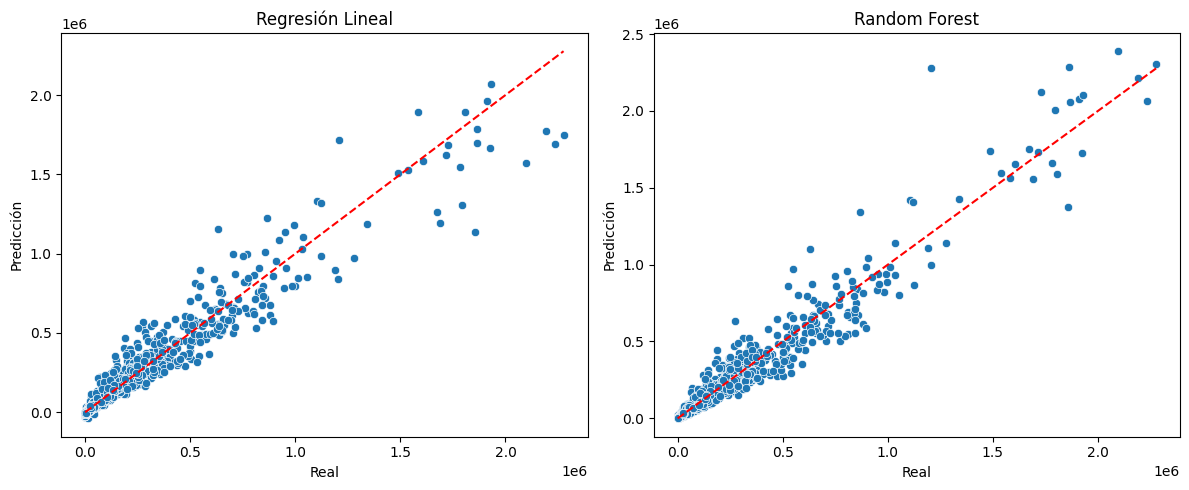

In [104]:
# Visualización comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_soja, y=y_pred_lr_soja)
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.title("Regresión Lineal")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_soja, y=y_pred_rf_soja)
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.tight_layout()
plt.show()

Hiperparámetros

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV

# Modelo base
#rf = RandomForestRegressor()

#param_grid = {
    #'n_estimators': [100, 300, 500],            # Más árboles pueden mejorar estabilidad
    #'max_depth': [10, 20, 30, None],            # Limita profundidad para evitar overfitting
    #'min_samples_split': [2, 5, 10],            # Min. muestras para dividir nodo
    #'min_samples_leaf': [1, 2, 4],              # Min. muestras en una hoja
    #'max_features': ['sqrt', 'log2', None]      # Qué fracción de features se considera}

# RandomizedSearch
#random_search_soja = RandomizedSearchCV(
    #estimator=rf,
    #param_distributions=param_grid,
    #n_iter=50,  # Cuántas combinaciones probar
    #cv=5,
    #verbose=2,
    #random_state=42,
    #n_jobs=-1)

# Entrenamiento
#random_search_soja.fit(X_train_soja, y_train_soja)

# Mejor modelo encontrado
#best_rf = random_search_soja.best_estimator_
#print("Mejores hiperparámetros:", random_search_soja.best_params_)


Mejores hiperparámetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}

In [105]:
# modifico hiperparámetros
rf_model_soja = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features='sqrt' , max_depth= 20, random_state=42)
rf_model_soja.fit(X_train_soja, y_train_soja)

y_pred_soja = rf_model_soja.predict(X_test_soja)

In [106]:
# Metricas
rms = mean_squared_error(y_test_soja, y_pred_soja)
mae = mean_absolute_error(y_test_soja, y_pred_soja)
r2 = r2_score(y_test_soja, y_pred_soja)


print('Modelos iniciales Soja')
print(f'Metricas para Regresión Lineal: MAE: {mae_soja_l:.2f} | R²: {r2_soja_l:.2f} | RMS: {rms_soja_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_soja_rf:.2f} | R²: {r2_soja_rf:.2f} | RMS: {rms_soja_rf:.2f}')
print('\n')
print('Modelos optimizados')
print(f'MAE: {mae:.2f} | R²: {r2:.2f} | RMS: {rms:.2f}')

Modelos iniciales Soja
Metricas para Regresión Lineal: MAE: 26247.54 | R²: 0.94 | RMS: 3624901577.65
Metricas para Random Forest: MAE: 19815.99 | R²: 0.95 | RMS: 3031742460.48


Modelos optimizados
MAE: 19250.19 | R²: 0.95 | RMS: 2834447325.71


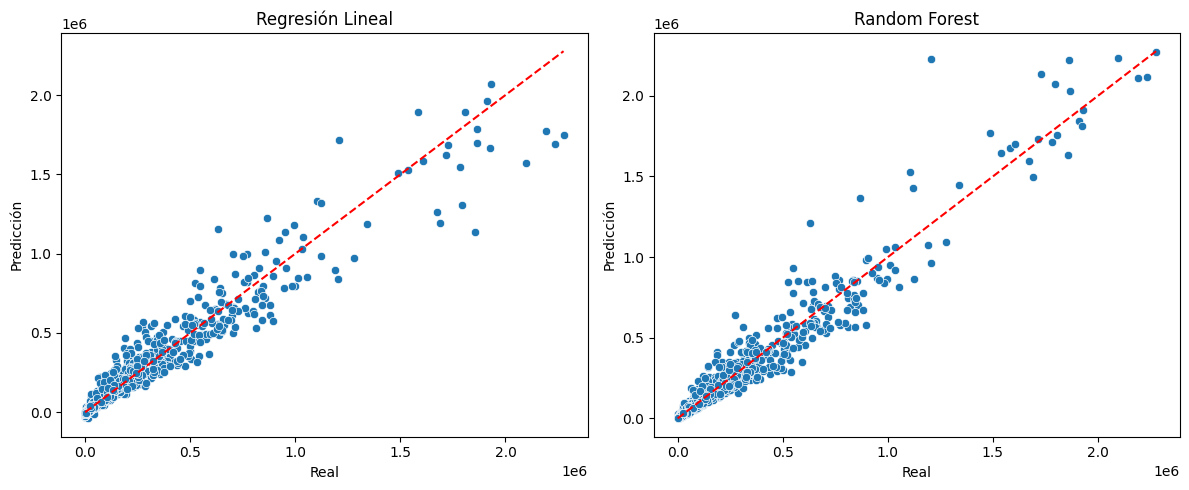

In [107]:
# Visualización comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_soja, y=y_pred_lr_soja)
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.title("Regresión Lineal")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_soja, y=y_pred_soja)
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.tight_layout()
plt.show()

La soja presentó patrones algo más sencillos comparados con el maíz, por lo que el modelo base ya rendía muy bien. La optimización ajustó algunos detalles reforzando la robustez sin cambiar radicalmente las métricas.

In [108]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    rf_model_soja,
    X_train_soja,
    y_train_soja,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

# Resultados promedio
print("\nVALIDACIÓN CRUZADA (5-fold):")
print(f"  MAE train:  {-cv_results['train_neg_mean_absolute_error'].mean():.2f}")
print(f"  MAE val:    {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"  RMSE train: {-cv_results['train_neg_root_mean_squared_error'].mean():.2f}")
print(f"  RMSE val:   {-cv_results['test_neg_root_mean_squared_error'].mean():.2f}")
print(f"  R² train:   {cv_results['train_r2'].mean():.3f}")
print(f"  R² val:     {cv_results['test_r2'].mean():.3f}")



VALIDACIÓN CRUZADA (5-fold):
  MAE train:  11736.57
  MAE val:    19634.88
  RMSE train: 31750.42
  RMSE val:   52629.85
  R² train:   0.981
  R² val:     0.948


La diferencia entre entrenamiento y validación no es exagerada, lo cual indica buena generalización y sin overfitting severo.

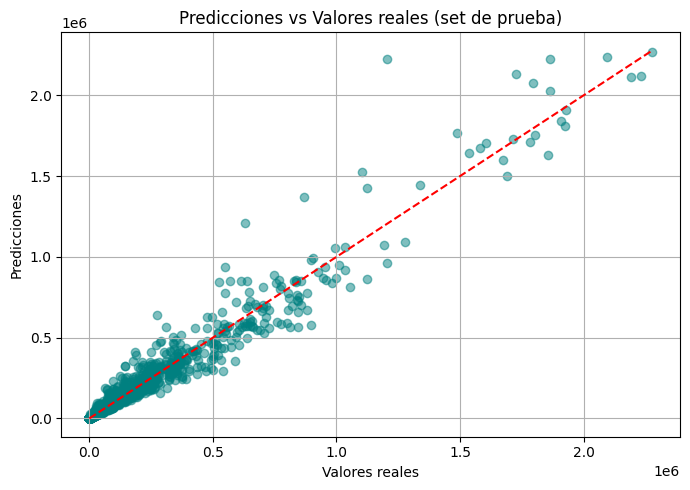

In [109]:
import matplotlib.pyplot as plt

y_pred_soja = rf_model_soja.predict(X_test_soja)

plt.figure(figsize=(7, 5))
plt.scatter(y_test_soja, y_pred_soja, alpha=0.5, color='teal')
plt.plot([y_test_soja.min(), y_test_soja.max()], [y_test_soja.min(), y_test_soja.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (set de prueba)')
plt.grid(True)
plt.tight_layout()
plt.show()


En los valores altos, algunas predicciones subestiman un poco. En general, el modelo capta bien la tendencia global.

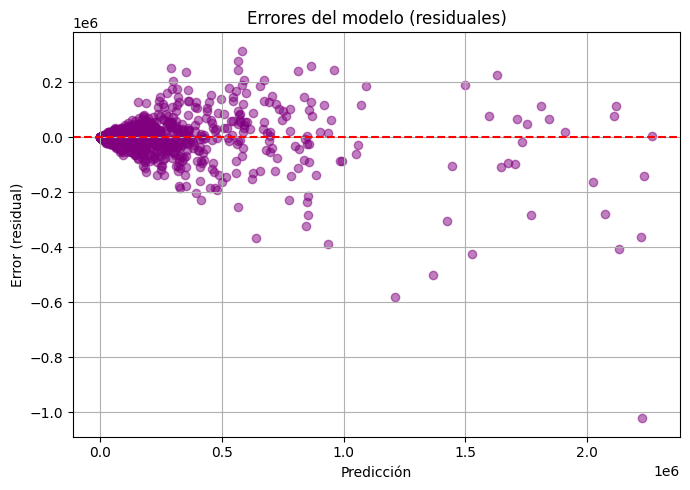

In [110]:
residuals_soja = y_test_soja - y_pred_soja

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_soja, residuals_soja, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicción')
plt.ylabel('Error (residual)')
plt.title('Errores del modelo (residuales)')
plt.grid(True)
plt.tight_layout()
plt.show()

El modelo tiene más dificultad con los valores más grandes, posiblemente por menor cantidad de muestras en ese rango.

### Cultivo: Trigo

Predecir la producción (en toneladas) de trigo para distintos años, regiones y superficies sembradas/cosechadas utilizando dos modelos:

- Regresión Lineal

- Random Forest Regressor (con búsqueda de hiperparámetros)

In [111]:
# Filtramos dataset por cultivo trigo
df_trigo = df[df['cultivo'] == 'Trigo total'].copy()

#Variables del modelo
X_trigo = df_trigo[['region', 'sup_sembrada_ha', 'sup_cosechada_ha', 'anio']]
y_trigo = df_trigo['produccion_ton']

# Codificación de la región
X_trigo = pd.get_dummies(X_trigo, columns=['region'], drop_first=True)

In [112]:
from sklearn.model_selection import train_test_split

X_train_trigo, X_test_trigo, y_train_trigo, y_test_trigo = train_test_split(X_trigo, y_trigo, test_size=0.2, random_state=42)

In [113]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 1: Regresión Lineal
lr_trigo = LinearRegression()
lr_trigo.fit(X_train_trigo, y_train_trigo)
y_pred_lr_trigo = lr_trigo.predict(X_test_trigo)

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# MODELO 2: Random Forest
rf_trigo = RandomForestRegressor(n_estimators=100, random_state=42)
rf_trigo.fit(X_train_trigo, y_train_trigo)
y_pred_rf_trigo = rf_trigo.predict(X_test_trigo)

In [115]:
# Metricas
rms_trigo_rf = mean_squared_error(y_test_trigo, y_pred_rf_trigo)
mae_trigo_rf = mean_absolute_error(y_test_trigo, y_pred_rf_trigo)
r2_trigo_rf = r2_score(y_test_trigo, y_pred_rf_trigo)

rms_trigo_l = mean_squared_error(y_test_trigo, y_pred_lr_trigo)
mae_trigo_l = mean_absolute_error(y_test_trigo, y_pred_lr_trigo)
r2_trigo_l = r2_score(y_test_trigo, y_pred_lr_trigo)

print(f'Metricas para Regresión Lineal: MAE: {mae_trigo_l:.2f} | R²: {r2_trigo_l:.2f} | RMS: {rms_trigo_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_trigo_rf:.2f} | R²: {r2_trigo_rf:.2f} | RMS: {rms_trigo_rf:.2f}')

Metricas para Regresión Lineal: MAE: 17655.14 | R²: 0.86 | RMS: 1005743249.05
Metricas para Random Forest: MAE: 11720.09 | R²: 0.89 | RMS: 776703048.07


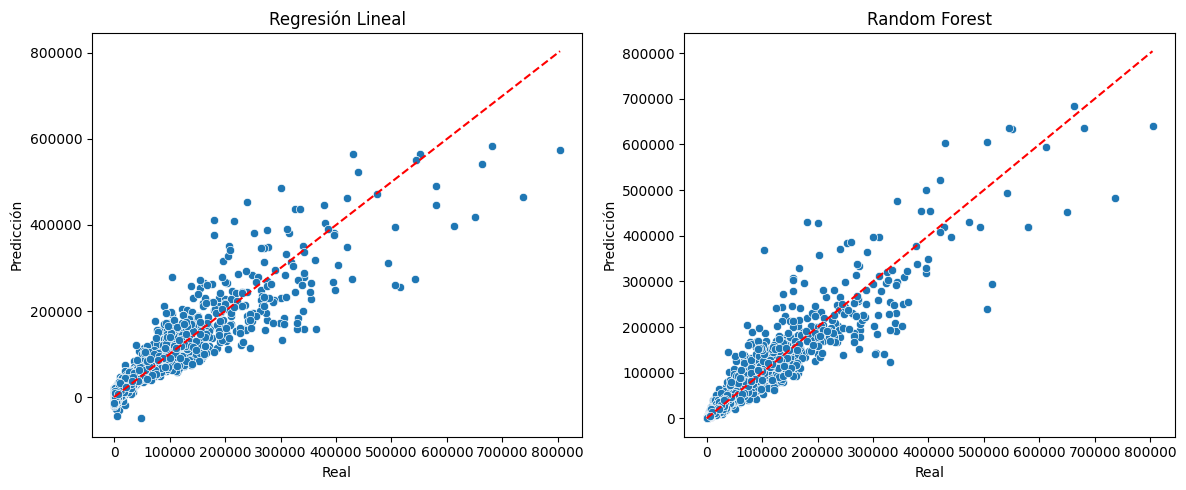

In [116]:
# Visualización comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_trigo, y=y_pred_lr_trigo)
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.title("Regresión Lineal")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_trigo, y=y_pred_rf_trigo)
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.tight_layout()
plt.show()

Hiperparámetros

In [ ]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV

# Modelo base
#rf = RandomForestRegressor()

#param_grid = {
    #'n_estimators': [100, 300, 500],            # Más árboles pueden mejorar estabilidad
    #'max_depth': [10, 20, 30, None],            # Limita profundidad para evitar overfitting
    #'min_samples_split': [2, 5, 10],            # Min. muestras para dividir nodo
    #'min_samples_leaf': [1, 2, 4],              # Min. muestras en una hoja
    #'max_features': ['sqrt', 'log2', None]      # Qué fracción de features se considera}

# RandomizedSearch
#random_search_trigo = RandomizedSearchCV(
    #estimator=rf,
    #param_distributions=param_grid,
    #n_iter=50,  # Cuántas combinaciones probar
    #cv=5,
    #verbose=2,
    #random_state=42,
    #n_jobs=-1)

# Entrenamiento
#random_search_trigo.fit(X_train_trigo, y_train_trigo)

# Mejor modelo encontrado
#best_rf = random_search_trigo.best_estimator_
#print("Mejores hiperparámetros:", random_search_trigo.best_params_)


Mejores hiperparámetros: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [117]:
# modifico hiperparámetros
rf_modelo_trigo = RandomForestRegressor(n_estimators=300, min_samples_split=10, min_samples_leaf=1, max_features='log2' , max_depth=30, random_state=42)
rf_modelo_trigo.fit(X_train_trigo, y_train_trigo)

y_pred_trigo = rf_modelo_trigo.predict(X_test_trigo)

In [118]:
# Metricas
rms = mean_squared_error(y_test_trigo, y_pred_trigo)
mae = mean_absolute_error(y_test_trigo, y_pred_trigo)
r2 = r2_score(y_test_trigo, y_pred_trigo)

print('Metricas inciales trigo')
print(f'Metricas para Regresión Lineal: MAE: {mae_trigo_l:.2f} | R²: {r2_trigo_l:.2f} | RMS: {rms_trigo_l:.2f}')
print(f'Metricas para Random Forest: MAE: {mae_trigo_rf:.2f} | R²: {r2_trigo_rf:.2f} | RMS: {rms_trigo_rf:.2f}')
print('\n')
print('Metricas optimizadas')
print(f'MAE: {mae:.2f} | R²: {r2:.2f} | RMS: {rms:.2f}')

Metricas inciales trigo
Metricas para Regresión Lineal: MAE: 17655.14 | R²: 0.86 | RMS: 1005743249.05
Metricas para Random Forest: MAE: 11720.09 | R²: 0.89 | RMS: 776703048.07


Metricas optimizadas
MAE: 11217.47 | R²: 0.90 | RMS: 662973094.13


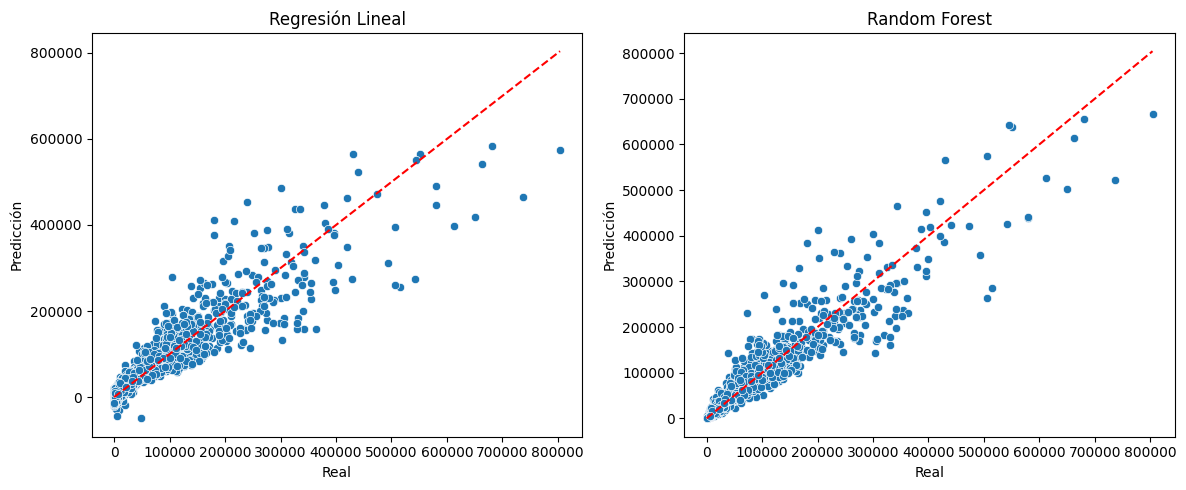

In [119]:
# Visualización comparativa
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_trigo, y=y_pred_lr_trigo)
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.title("Regresión Lineal")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_trigo, y=y_pred_trigo)
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.title("Random Forest")
plt.xlabel("Real")
plt.ylabel("Predicción")

plt.tight_layout()
plt.show()

El trigo mostró una estructura productiva algo intermedia entre soja y maíz. El Random Forest capturó relaciones más complejas que la lineal, y la afinación de hiperparámetros reforzó aún más la exactitud.

El modelo Random Forest optimizado es el candidato ideal para cada cultivo. Proporciona predicciones confiables para planificación, estimación de stock, precios o impacto climático.

In [120]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    rf_modelo_trigo,
    X_train_trigo,
    y_train_trigo,
    cv=5,
    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'],
    return_train_score=True
)

# Resultados promedio
print("\nVALIDACIÓN CRUZADA (5-fold):")
print(f"  MAE train:  {-cv_results['train_neg_mean_absolute_error'].mean():.2f}")
print(f"  MAE val:    {-cv_results['test_neg_mean_absolute_error'].mean():.2f}")
print(f"  RMSE train: {-cv_results['train_neg_root_mean_squared_error'].mean():.2f}")
print(f"  RMSE val:   {-cv_results['test_neg_root_mean_squared_error'].mean():.2f}")
print(f"  R² train:   {cv_results['train_r2'].mean():.3f}")
print(f"  R² val:     {cv_results['test_r2'].mean():.3f}")



VALIDACIÓN CRUZADA (5-fold):
  MAE train:  8719.07
  MAE val:    12486.64
  RMSE train: 21203.72
  RMSE val:   30703.61
  R² train:   0.945
  R² val:     0.884


La pequeña caída de R² (de 0.945 a 0.884) y el incremento moderado de los errores indican que el modelo no está sobreajustado, aunque sí hay una pérdida de precisión, especialmente en los extremos.

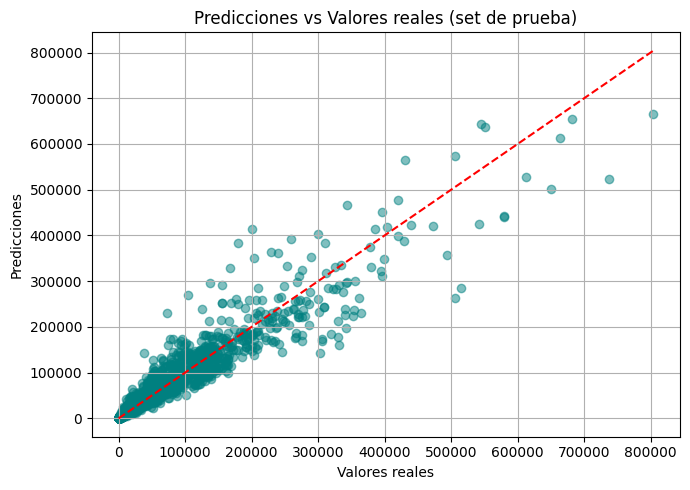

In [121]:
import matplotlib.pyplot as plt

y_pred_trigo = rf_modelo_trigo.predict(X_test_trigo)

plt.figure(figsize=(7, 5))
plt.scatter(y_test_trigo, y_pred_trigo, alpha=0.5, color='teal')
plt.plot([y_test_trigo.min(), y_test_trigo.max()], [y_test_trigo.min(), y_test_trigo.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales (set de prueba)')
plt.grid(True)
plt.tight_layout()
plt.show()


En valores de producción altos (mayores a 100 mil), el modelo subestima la producción (los puntos están por debajo de la línea diagonal).

En producciones bajas y medias, el ajuste es mucho más preciso.

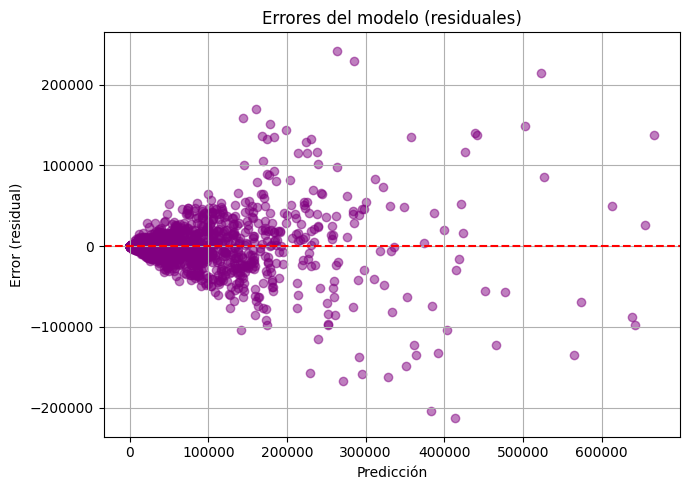

In [122]:
residuals_trigo = y_test_trigo - y_pred_trigo

plt.figure(figsize=(7, 5))
plt.scatter(y_pred_trigo, residuals_trigo, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicción')
plt.ylabel('Error (residual)')
plt.title('Errores del modelo (residuales)')
plt.grid(True)
plt.tight_layout()
plt.show()

Hay una leve dispersión hacia la derecha (errores positivos más frecuentes), lo que refuerza la idea de que el modelo tiende a subestimar en ciertos casos.

No hay colas exageradas ni outliers extremos, lo que indica que el modelo es estable.

## **Comentarios finales**

A pesar de que el modelo entrenado sobre el dataset completo —es decir, sin distinguir entre cultivos— presentó un rendimiento global sobresaliente (R² = 0,995; MAE = 1.121,57), se optó por construir modelos específicos para cada cultivo (soja, maíz y trigo). Esta decisión se fundamenta en tres razones principales. En primer lugar, cada cultivo responde de manera distinta a las variables agroclimáticas y edáficas, lo cual se traduce en relaciones particulares que un único modelo no logra capturar con precisión. En segundo lugar, al trabajar con un modelo general, existe el riesgo de que se favorezca al cultivo predominante en términos de volumen o cantidad de registros, afectando negativamente la capacidad de predicción sobre los demás. Por último, los modelos separados permiten estimaciones específicas de producción por cultivo, lo cual es esencial para la toma de decisiones agronómicas, económicas y de política pública. En todos los casos, los modelos individuales alcanzaron niveles de ajuste satisfactorios (R² ≥ 0,90), lo que confirma la validez de esta estrategia.